#Kodiak Take-Home Report: Shape–Color Recognition with HSV Masking + Per-Color Multi-Label Classifier

**Below is my submission for the Kodiak take-home assignment titled 'All Shapes and Colors'. This was approached using three different methods based on increasing performance and complexity.**

##1. Goal and Problem Setting

Predict the set of shape–color pairs present in each image. Shapes are circle, square, triangle. Colors are red, green, blue. Images may contain multiple shapes, including multiple of the same color, and overlaps are common. Submissions require a Python-literal string of tuples like [('triangle', 'red'), ('square', 'blue')]. Evaluation is the mean Jaccard similarity between predicted and ground-truth sets per image.

##2. Approaches Explored and What We Learned

###2.1 Classical CV only

* HSV thresholding per color, contour extraction, polygon approximation and circle heuristics.

* Worked forclean non-overlapping cases. Presumed to break when shapes overlapped or when one color occluded another causing “bites” in the lower mask. Morphological closing helped a little but not robustly.

###2.2 End-to-end multi-label CNN on the full RGB

* Single backbone with 9 sigmoid outputs for the 9 shape–color pairs.

* Issues encountered: data augmentation that removed shapes created label noise, plus sensitivity to color calibration pitfalls. This worked to some degree of accuracy but was fussy to stabilize quickly. Was incapable of consistently classifying multiple overlapping shapes of different colors. Jaccard score did not appear to converge during training, meaning final model would yield different levels of accuracy during separate training runs. This is not an ideal solution, as it indicates the pipeline is not the correct approach for a consistent, highly accurate solution.

###2.3 Final approach: Hybrid CV + per-color multi-label classifier

* Used classical CV only to separate colors via HSV into three binary masks.

* Trained one shared classifier that sees a single color’s binary mask and predicts which shapes of that color are present with three independent sigmoids [circle, square, triangle].

* Combined the three color-specific predictions into the final set.

* This removed color complexity from learning and made partial occlusions tractable since the model only needed to infer geometry from a binary silhouette.

##3. Key Design Decisions

###3.1 Color space and masking

* Convert BGR to HSV.

* Red uses a dual hue window because hue is circular.

* Thresholds are on S and V to suppress near-gray and very dark regions.

* Output a 0 or 255 binary mask per color.

* Optional morphological closing with a small kernel to heal thin gaps. This was used because it showed to help in classical CV method.

###3.2 Representation given to the model

* Input per sample is the binary mask for one color.

* Repeat the single channel three times so ImageNet-pretrained backbones can be used unchanged.

* No explicit color one-hot is passed. The fact that we are on the “red stream” versus “blue stream” is implicit because the mask was produced by that color’s thresholds.

###3.3 Labels and loss

* For each color predict a 3-dimensional multi-label vector [is_circle, is_square, is_triangle].

* Use BCEWithLogitsLoss for these three independent yes or no decisions.

###3.4 Backbone choice

* Start with ResNet-152 for strong baseline. ViT-B16 was also an option for a more powerful vision model but was not needed.

* Final FC head outputs three logits per color sample.

###3.5 Augmentations

* Avoid any augmentation that can delete parts of a shape while keeping its positive label, for example aggressive random crops or strong perspective transforms.

* Use geometry-preserving transforms: resize to 256, center crop to 224, small rotation, mild affine translate and scale, brightness and contrast only. No hue or saturation jitter because color semantics are in the masking step.

##4. Training Pipeline

1. Load image.

2. Produce HSV masks for red, green, blue. Optional single-iteration morphological closing.

3. For each color:

    * Convert the mask into a three-channel tensor and apply the same normalization as the backbone’s ImageNet stats.

    * Target is the three-bit vector for shapes of that color.

4. Train with AdamW, lr around 1e-4, weight decay 1e-4.

5. Validation:

    * Run the same per-color forward pass.

    * Regroup per image: apply threshold 0.5 to the three color vectors, map positives back to tuples, and compute per-image Jaccard against the ground truth. Report the mean.

#Implementation

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import PIL
from PIL import Image

In [4]:
ROOT = Path('/content/drive/MyDrive/Kodiak Assignment/dataset_v3')
csv_path = ROOT / 'train.csv'
df = pd.read_csv(csv_path)

In [5]:
df.head()

,image_path,label
0,train_dataset/img_0.png,"[('triangle', 'red'), ('square', 'green')]"
1,train_dataset/img_1.png,"[('triangle', 'green'), ('circle', 'blue')]"
2,train_dataset/img_2.png,"[('square', 'green'), ('triangle', 'green')]"
3,train_dataset/img_3.png,"[('circle', 'blue')]"
4,train_dataset/img_4.png,"[('circle', 'green')]"


In [6]:
df.loc[0, 'image_path']

'train_dataset/img_0.png'

In [82]:
df.loc[0, 'label']

"[('triangle', 'red'), ('square', 'green')]"

In [7]:
## Downloading images from Drive onto Colab's local SSD for faster training

SRC = "/content/drive/MyDrive/Kodiak Assignment/dataset_v3/train_dataset"
DST = "/content/train_dataset"  # local SSD

!mkdir -p "$DST"
# rsync shows progress, preserves structure, and is faster than cp
!rsync -ah --info=progress2 "$SRC"/ "$DST"/


         90.02M 100%  451.43kB/s    0:03:14 (xfr#5000, to-chk=0/5001)


In [8]:
SRC = "/content/drive/MyDrive/Kodiak Assignment/dataset_v3/test_dataset"
DST = "/content/test_dataset"  # local SSD

!mkdir -p "$DST"
!rsync -ah --info=progress2 "$SRC"/ "$DST"/


         23.50M 100%  895.86kB/s    0:00:25 (xfr#1000, to-chk=0/1001)


##Classical Method

Because of the simplicity of the classification task, my initial idea was to use a purely classical approach using color masks and edge detection for shapes.

In [9]:

def to_hsv(img_bgr):
  """Converts original BGR image to HSV format."""
  return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV) # HSV image has shape [height, width, channel]

def colour_masks_hsv(img_bgr):
  """Creates masked images for each colour based on HSV ranges."""
  hsv = to_hsv(img_bgr)

  s_min = 60
  v_min = 60

  red1 = cv2.inRange(hsv, (0, s_min, v_min), (10, 255, 255)) # returns binary mask for in range or not in range
  red2 = cv2.inRange(hsv, (170, s_min, v_min), (180, 255, 255)) # CV halves the hue circle from 360 to 180, so red wraps around at 180
  red = cv2.bitwise_or(red1, red2)
  green = cv2.inRange(hsv, (35, s_min, v_min), (85, 255, 255))
  blue = cv2.inRange(hsv, (90, s_min, v_min), (130, 255, 255))

  return {"red": red, "green": green, "blue": blue}, hsv

def clean_mask(mask, k_size=3, iters=1):
  """Opening and closing to clean up images from noise"""
  # k = np.ones((k_size, k_size), np.uint8) # kernel size for erosion/dilation
  k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_size, k_size)) # shape and size of kernel performing morph

  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=iters)
  mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k, iterations=iters)

  return mask

# def edges_within_colour(mask):
#   edges = cv2.Canny(mask, )







However, after displaying some masked images (as shown below), I realized that any intersecting shapes would cut out chunks of each other. If a significant portion of the shapes were interlapping, there would be no certainty that edge detection (even more advanced methods like Canny or Watershed) would be able to recognize different shapes. The displayed image below was theoretically a best case scenario.

In [10]:
rel_path = ROOT / df.loc[17, 'image_path']
img = cv2.imread(str(rel_path), cv2.IMREAD_COLOR)
display_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

array([[[226, 226, 226],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [226, 226, 226],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [226, 226, 226],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[230, 230, 230],
        [230, 230, 230],
        [230, 230, 230],
        ...,
        [234, 234, 234],
        [234, 234, 234],
        [255, 255, 255]],

       [[230, 230, 230],
        [230, 230, 230],
        [230, 230, 230],
        ...,
        [234, 234, 234],
        [234, 234, 234],
        [255, 255, 255]],

       [[230, 230, 230],
        [230, 230, 230],
        [230, 230, 230],
        ...,
        [234, 234, 234],
        [234, 234, 234],
        [255, 255, 255]]], dtype=uint8)
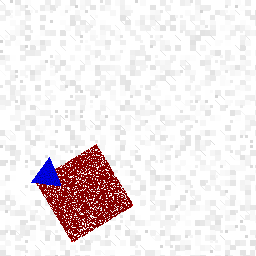

In [11]:
display_img

In [12]:
hsv = to_hsv(img)

array([[[  0,   0, 226],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 226],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 226],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 230],
        [  0,   0, 230],
        [  0,   0, 230],
        ...,
        [  0,   0, 234],
        [  0,   0, 234],
        [  0,   0, 255]],

       [[  0,   0, 230],
        [  0,   0, 230],
        [  0,   0, 230],
        ...,
        [  0,   0, 234],
        [  0,   0, 234],
        [  0,   0, 255]],

       [[  0,   0, 230],
        [  0,   0, 230],
        [  0,   0, 230],
        ...,
        [  0,   0, 234],
        [  0,   0, 234],
        [  0,   0, 255]]], dtype=uint8)
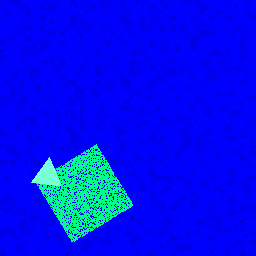

In [13]:
hsv

In [14]:
shapes, hsv = colour_masks_hsv(img)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
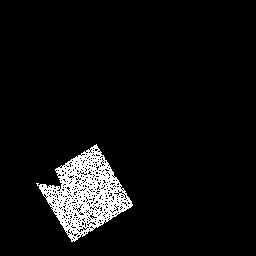

In [15]:
shapes['red']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
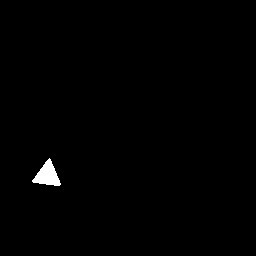

In [16]:
clean_mask(shapes['blue'], k_size=3)

##End-to-end CNN Version

Ruling out classical edge detection meant an vision model-based approach would be most appropriate.

In [17]:
import ast
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torch.nn as nn
from torchvision.models import resnet152, ResNet152_Weights
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [18]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

In [19]:
## Classes and mappings

classes = [('circle', 'red'), ('circle', 'green'), ('circle', 'blue'),
           ('square', 'red'), ('square', 'green'), ('square', 'blue'),
           ('triangle', 'red'), ('triangle', 'green'), ('triangle', 'blue')]

class2idx = {p:i for i,p in enumerate(classes)}

In [20]:
## Parsing strings

def parse_label_string(s):
  if isinstance(s, float) and pd.isna(s):
    return []
  pairs = ast.literal_eval(s)
  return [(a.strip(), b.strip()) for a, b in pairs]

In [21]:
## Custom dataset for images

class ShapesDataset(Dataset):
  def __init__(self, df, img_dir, transform=None):
    self.df = df
    self.img_dir = Path(img_dir)
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]
    img = Image.open(self.img_dir/row['image_path']).convert('RGB')
    if self.transform:
      img = self.transform(img)
    y = torch.zeros(9, dtype=torch.float32)
    if 'label' in row and isinstance('label', str):
      for p in parse_label_string(row['label']):
        if p in class2idx:
          y[class2idx[p]] = 1.0
    return img, y

In [ ]:
## Keeping transforms relatively simple to avoid cropping out shapes or colors

cnn_transforms = {
    'train': T.Compose([
      T.RandomRotation(30),
      T.ColorJitter(brightness=0.2, contrast=0.2),  # avoid hue/sat jitter
      T.ToTensor(),
      T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ]),
    'val': T.Compose([
      T.Resize(256), T.CenterCrop(224),
      T.ToTensor(),
      T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])
}

cnn_model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)
in_features = cnn_model.fc.in_features
cnn_model.fc = nn.Linear(in_features, 9)
cnn_model.to(device)

In [23]:
def jaccard_from_logits(logits, y_true, thresholds):
  probs = torch.sigmoid(logits).cpu().numpy()
  y_pred = (logits >= np.asarray(thresholds)).astype(bool)
  y_true = np.asarray(y_true).astype(bool)
  intersection = np.logical_and(y_pred, y_true).sum()
  union = np.logical_or(y_pred, y_true).sum()
  return 1.0 if union == 0 else intersection/union

def jaccard_from_logits_torch(logits, y_true, thresholds):
  # logits: torch.Tensor (N, 9)
  # y_true: torch.Tensor (N, 9) ints {0,1}
  # thresholds: array-like (9,)
  probs = torch.sigmoid(logits)          # (N, 9)
  thr = torch.as_tensor(thresholds, device=probs.device).unsqueeze(0)
  y_pred = (probs >= thr)                     # bool (N, 9)
  y_true = y_true.to(probs.device).bool()     # bool (N, 9)

  inter = (y_pred & y_true).sum(dim=1)
  union = (y_pred | y_true).sum(dim=1)
  jac = torch.where(union == 0, torch.ones_like(union, dtype=torch.float32),
                    inter.float() / union.float())
  return jac.mean().item()

In [24]:
img_dir = '/content'
cnn_train_df, cnn_val_df = train_test_split(df, test_size=0.2, random_state=42)
cnn_train_df = cnn_train_df.reset_index(drop=True)
cnn_val_df = cnn_val_df.reset_index(drop=True)

cnn_dfs = {'train': cnn_train_df, 'val': cnn_val_df}


cnn_datasets = {x: ShapesDataset(cnn_dfs[x], img_dir, cnn_transforms[x]) for x in ['train', 'val']}

cnn_dataloaders = {x: DataLoader(cnn_datasets[x],
                             shuffle=('True' if x=='train' else 'False'),
                             num_workers=6,
                             persistent_workers=True,
                             pin_memory=True)
              for x in ['train', 'val']}

In [25]:
cnn_criterion = nn.BCEWithLogitsLoss()
cnn_optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=1e-4, weight_decay=1e-4)

In [26]:
def train_model(model, criterion, optimizer, num_epochs):
  best = (-1, None, None)  # jaccard, state_dict, thresholds
  thrs = np.full(9, 0.5)

  for epoch in range(1, num_epochs + 1):
    for phase in ['train', 'val']:
      # train
      if phase =='train':
        model.train()
        iterator = cnn_dataloaders[phase]
        iterator = tqdm(iterator, desc=f"[epoch {epoch}/{num_epochs}] train", leave=False)

        train_loss_sum, train_seen = 0.0, 0
        for x, y in iterator:
          x, y = x.to(device), y.to(device)
          optimizer.zero_grad()
          logits = model(x)
          loss = criterion(logits, y)

          loss.backward()
          optimizer.step()

          iterator.set_postfix(loss=float(loss.item()))

          bs = x.size(0)
          train_seen += bs
          train_loss_sum += loss.item() * bs

        train_loss = train_loss_sum / max(1, train_seen)

      # val
      else:
        model.eval()
        all_logits, all_y = [], []
        iterator = cnn_dataloaders['val']
        iterator = tqdm(iterator, desc=f"[epoch {epoch}/{num_epochs}] val  ", leave=False)

        val_loss_sum, val_seen = 0.0, 0
        with torch.no_grad():
          for x, y in iterator:
            x = x.to(device)
            all_logits.append(model(x).cpu())
            all_y.append(y)

            val_loss_sum += criterion(logits, y.to(device)).item() * x.size(0)
            val_seen += x.size(0)

        iterator.close()

        L = torch.cat(all_logits)
        Y = torch.cat(all_y)
        val_loss = val_loss_sum / max(1, val_seen)

        jac = jaccard_from_logits_torch(L, Y, thrs)


        print(f"epoch {epoch}: train_loss={train_loss:.4f} "
              f"val_loss={val_loss:.4f} val_Jaccard={jac:.4f} "
              f"thrs={np.round(thrs,2)}")

        if jac > best[0]:
          best = (jac, {k:v.cpu() for k,v in model.state_dict().items()}, thrs.copy())
        print(f"epoch {epoch}: val Jaccard={jac:.4f}, thrs={np.round(thrs,2)}")

  model.load_state_dict(best[1])
  return model, best[2]


In [27]:
cnn_model, threshold = train_model(cnn_model, cnn_criterion, cnn_optimizer, 10)

[epoch 1/10] train:   0%|          | 0/4000 [00:00<?, ?it/s]

[epoch 1/10] val  :   0%|          | 0/1000 [00:00<?, ?it/s]

epoch 1: train_loss=0.1129 val_loss=1.8149 val_Jaccard=0.9722 thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
epoch 1: val Jaccard=0.9722, thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


[epoch 2/10] train:   0%|          | 0/4000 [00:00<?, ?it/s]

[epoch 2/10] val  :   0%|          | 0/1000 [00:00<?, ?it/s]

epoch 2: train_loss=0.0355 val_loss=2.2625 val_Jaccard=0.7874 thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
epoch 2: val Jaccard=0.7874, thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


[epoch 3/10] train:   0%|          | 0/4000 [00:00<?, ?it/s]

[epoch 3/10] val  :   0%|          | 0/1000 [00:00<?, ?it/s]

epoch 3: train_loss=0.0247 val_loss=2.9249 val_Jaccard=0.8418 thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
epoch 3: val Jaccard=0.8418, thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


[epoch 4/10] train:   0%|          | 0/4000 [00:00<?, ?it/s]

[epoch 4/10] val  :   0%|          | 0/1000 [00:00<?, ?it/s]

epoch 4: train_loss=0.0227 val_loss=1.6784 val_Jaccard=0.8320 thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
epoch 4: val Jaccard=0.8320, thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


[epoch 5/10] train:   0%|          | 0/4000 [00:00<?, ?it/s]

[epoch 5/10] val  :   0%|          | 0/1000 [00:00<?, ?it/s]

epoch 5: train_loss=0.0198 val_loss=2.5914 val_Jaccard=0.8565 thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
epoch 5: val Jaccard=0.8565, thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


[epoch 6/10] train:   0%|          | 0/4000 [00:00<?, ?it/s]

[epoch 6/10] val  :   0%|          | 0/1000 [00:00<?, ?it/s]

epoch 6: train_loss=0.0171 val_loss=2.8473 val_Jaccard=0.8584 thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
epoch 6: val Jaccard=0.8584, thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


[epoch 7/10] train:   0%|          | 0/4000 [00:00<?, ?it/s]

[epoch 7/10] val  :   0%|          | 0/1000 [00:00<?, ?it/s]

epoch 7: train_loss=0.0120 val_loss=2.9977 val_Jaccard=0.8120 thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
epoch 7: val Jaccard=0.8120, thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


[epoch 8/10] train:   0%|          | 0/4000 [00:00<?, ?it/s]

[epoch 8/10] val  :   0%|          | 0/1000 [00:00<?, ?it/s]

epoch 8: train_loss=0.0116 val_loss=2.4556 val_Jaccard=0.8109 thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
epoch 8: val Jaccard=0.8109, thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


[epoch 9/10] train:   0%|          | 0/4000 [00:00<?, ?it/s]

[epoch 9/10] val  :   0%|          | 0/1000 [00:00<?, ?it/s]

epoch 9: train_loss=0.0120 val_loss=2.3159 val_Jaccard=0.6580 thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
epoch 9: val Jaccard=0.6580, thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


[epoch 10/10] train:   0%|          | 0/4000 [00:00<?, ?it/s]

[epoch 10/10] val  :   0%|          | 0/1000 [00:00<?, ?it/s]

epoch 10: train_loss=0.0120 val_loss=2.8404 val_Jaccard=0.8408 thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
epoch 10: val Jaccard=0.8408, thrs=[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


While Jaccard accuracy reaches 97% here on the first epoch, this was the best score achieved across any training run and within this specific training loop. The score seems to stay fairly level around 80% throughout subsequent epochs but shows no signs of convergence, meaning confidence should not be placed in this model.

In [28]:
test_path = '/content/' + cnn_val_df.loc[0, 'image_path']

In [29]:
test_img = Image.open(test_path).convert('RGB')

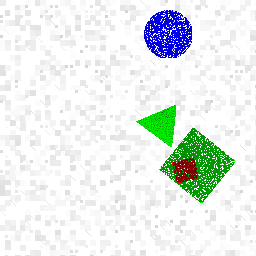

In [30]:
test_img

In [31]:
test_path = '/content/' + cnn_val_df.loc[0, 'image_path']
img = Image.open(test_path).convert('RGB')
x = cnn_transforms['val'](img)
x = x.unsqueeze(0).to(device)

with torch.no_grad():
    logits = cnn_model(x)
    probs = torch.sigmoid(logits).squeeze(0).cpu().numpy()

In [32]:
thrs_vec = np.full(9, 0.5)
pred_idx = np.where(probs >= thrs_vec)[0].tolist()

In [33]:
pred_idx

[2, 4, 7]

##Hybrid Approach (CV + Model)

In [34]:
import os, ast, cv2, math, numpy as np, pandas as pd
from pathlib import Path
from PIL import Image
from collections import defaultdict

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# Re-initializing constants if running this model independently
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMG_DIR = "/content"

COLORS = ["red", "green", "blue"]
SHAPES = ["circle", "square", "triangle"]


In [35]:
## Image pre-preprocessing

def color_masks_hsv(img_bgr, s_min=40, v_min=40):
    """Return 0/255 masks for red/green/blue. img_bgr is uint8 BGR."""
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    red1 = cv2.inRange(hsv, (0,   s_min, v_min), (20, 255, 255))
    red2 = cv2.inRange(hsv, (150, s_min, v_min), (179,255, 255))
    red  = cv2.bitwise_or(red1, red2)

    green= cv2.inRange(hsv, (35,  s_min, v_min), (85,  255, 255))
    blue = cv2.inRange(hsv, (90,  s_min, v_min), (130, 255, 255))
    return {"red": red, "green": green, "blue": blue}

def morph_clean(mask, ksize=3, iters=1):
    """Light close to heal small gaps. Keeps shapes filled under occlusion."""
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize)) # shape and size of kernel performing morph
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=iters)


In [36]:
def parse_label_str(s):
    if not isinstance(s, str) or not s.strip():
        return []
    return [(a.strip(), b.strip()) for a, b in ast.literal_eval(s)]

def target_for_color(gt_pairs, color):
    # logical 1.0 if shape is in gt_pairs
    return torch.tensor([
        int(("circle",   color) in gt_pairs),
        int(("square",   color) in gt_pairs),
        int(("triangle", color) in gt_pairs),
    ], dtype=torch.float32)


In [37]:
class ColorMaskMultiLabelDS(Dataset):
    """
      Length = 3 * N_images. Each item = (x, y, meta)
      x: (3,H,W) float tensor in [0,1] or normalized; 3 channels are the repeated binary mask
      y: (3,) float in {0,1} for [circle, square, triangle]
      meta: {"image_idx": i, "color": str}
    """
    def __init__(self, df, img_dir, transform=None, use_morph=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.use_morph = use_morph
        self.index = [(i, c) for i in range(len(self.df)) for c in range(3)]

    def __len__(self):
        return len(self.index)

    def __getitem__(self, i):
        img_idx, cidx = self.index[i]
        row = self.df.iloc[img_idx]
        img_path = self.img_dir / row["image_path"]
        bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        if bgr is None:
            raise FileNotFoundError(img_path)

        masks = color_masks_hsv(bgr)
        color = COLORS[cidx]
        mask = masks[color]
        if self.use_morph:
            mask = morph_clean(mask, ksize=3, iters=1)

        # binary mask -> (3,H,W) float tensor
        m = (mask.astype(np.float32) / 255.0)   # (H,W)
        x_np = np.stack([m, m, m], axis=0)
        x = torch.from_numpy(x_np)

        # compose with ToTensor/Normalize usually expects PIL
        pil = Image.fromarray((m*255).astype(np.uint8))
        # make 3-ch PIL by duplicating
        pil3 = pil.convert("RGB")
        x = self.transform(pil3)  # (3,H,W) normalized


        gt_pairs = set(parse_label_str(row.get("label", "[]")))
        y = target_for_color(gt_pairs, color)   # (3,)

        meta = {"image_idx": img_idx, "color": color}
        return x, y, meta


In [38]:
hy_train_tf = T.Compose([
    T.Resize(256), T.CenterCrop(224),
    T.RandomRotation(30),
    T.RandomAffine(degrees=0, translate=(0.08,0.08), scale=(0.9,1.1)),
    # brightness/contrast only no hue/sat jitter
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

hy_val_tf = T.Compose([
    T.Resize(256), T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])


In [39]:
def make_model(backbone="resnet152"):
    if backbone.lower() == "resnet152":
        m = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
        m.fc = nn.Linear(m.fc.in_features, 3)
        return m
    elif backbone.lower() in ("vit", "vit_b_16"):
        m = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
        m.heads.head = nn.Linear(m.heads.head.in_features, 3)
        return m
    else:
        raise ValueError("backbone must be 'resnet152' or 'vit_b_16'")


In [40]:
img_dir = '/content'
hy_train_df, hy_val_df = train_test_split(df, test_size=0.2, random_state=42)

USE_MORPH = True
hy_train_ds = ColorMaskMultiLabelDS(hy_train_df, IMG_DIR, transform=hy_train_tf, use_morph=USE_MORPH)
hy_val_ds   = ColorMaskMultiLabelDS(hy_val_df, IMG_DIR, transform=hy_val_tf, use_morph=USE_MORPH)

hy_train_dl = DataLoader(hy_train_ds, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True, persistent_workers=True)
hy_val_dl  = DataLoader(hy_val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)

hy_model = make_model("resnet152").to(device)
hy_criterion = nn.BCEWithLogitsLoss()
hy_optimizer = torch.optim.AdamW(hy_model.parameters(), lr=1e-4, weight_decay=1e-4)

hy_dataloaders = {"train": hy_train_dl, "val": hy_val_dl}


In [41]:
def agg_pred_sets(per_img_color_vecs, thr=(0.5,0.5,0.5)):
    """per_img_color_vecs: dict color -> np.array(3,) of probs or 0/1"""
    out = set()
    thr = np.asarray(thr)
    for color in COLORS:
        v = np.asarray(per_img_color_vecs.get(color, np.zeros(3)))
        bin3 = (v >= thr).astype(int)
        for s_idx, flag in enumerate(bin3):
            if flag:
                out.add((SHAPES[s_idx], color))
    return out

@torch.no_grad()
def evaluate(model, loader, df_val, thr=(0.5,0.5,0.5)):
    model.eval()
    per_image_pred = defaultdict(lambda: {c: np.zeros(3, dtype=float) for c in COLORS})
    for x, y, meta in loader:
        x = x.to(device)
        logits = model(x)                   # (B,3)
        probs = torch.sigmoid(logits).cpu().numpy()
        # each row corresponds to one color-sample
        # store probabilities (not hard 0/1) so Jaccard uses threshold later (not necessary with fixed threshold)
        for i in range(len(probs)):
            img_idx = int(meta["image_idx"][i])
            color   = meta["color"][i]
            per_image_pred[img_idx][color] = probs[i]

    # compute Jaccard across images
    scores = []
    dfv = df_val.reset_index(drop=True)
    for img_idx, row in dfv.iterrows():
        gt = set(parse_label_str(row.get("label","[]")))
        pr = agg_pred_sets(per_image_pred.get(img_idx, {}), thr=thr)
        inter = len(gt & pr); union = len(gt | pr)
        scores.append(1.0 if union == 0 else inter/union)
    return float(np.mean(scores))


In [42]:
def train(model, dataloaders, criterion, optimizer, epochs=8, thr=(0.5,0.5,0.5)):
    best = (-1.0, None)
    for epoch in range(1, epochs+1):
        # train
        model.train()
        tr_loss_sum, tr_seen = 0.0, 0
        for x, y, _ in tqdm(hy_dataloaders["train"], desc=f"[epoch {epoch}/{epochs}] train", leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(x)                 # (B,3)
            loss = criterion(logits, y)       # BCE multi-label per color
            loss.backward(); optimizer.step()
            bs = x.size(0); tr_seen += bs
            tr_loss_sum += loss.item() * bs
        train_loss = tr_loss_sum / max(1, tr_seen)

        # val
        model.eval()
        va_loss_sum, va_seen = 0.0, 0
        with torch.no_grad():
            for x, y, _ in hy_dataloaders["val"]:
                x = x.to(device)
                y = y.to(device)
                logits = model(x)
                va_loss_sum += criterion(logits, y).item() * x.size(0)
                va_seen += x.size(0)
        val_loss = va_loss_sum / max(1, va_seen)

        # aggregated Jaccard per image
        val_jac = evaluate(model, hy_dataloaders["val"], hy_val_df, thr=thr)

        print(f"epoch {epoch}: train_loss={train_loss:.4f} "
              f"val_loss={val_loss:.4f} val_Jaccard={val_jac:.4f} thr={thr}")

        if val_jac > best[0]:
            best = (val_jac, {k:v.cpu() for k,v in model.state_dict().items()})
            print("New best checkpoint")

    model.load_state_dict(best[1])
    print(f"Best val Jaccard = {best[0]:.4f}")
    return model

In [43]:
hy_model = train(hy_model, hy_dataloaders, hy_criterion, hy_optimizer, epochs=8)

[epoch 1/8] train:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 1: train_loss=0.1102 val_loss=0.0222 val_Jaccard=0.9942 thr=(0.5, 0.5, 0.5)
New best checkpoint


[epoch 2/8] train:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 2: train_loss=0.0451 val_loss=0.0218 val_Jaccard=0.9970 thr=(0.5, 0.5, 0.5)
New best checkpoint


[epoch 3/8] train:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 3: train_loss=0.0412 val_loss=0.0123 val_Jaccard=0.9965 thr=(0.5, 0.5, 0.5)


[epoch 4/8] train:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 4: train_loss=0.0332 val_loss=0.0072 val_Jaccard=0.9962 thr=(0.5, 0.5, 0.5)


[epoch 5/8] train:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 5: train_loss=0.0356 val_loss=0.0102 val_Jaccard=0.9960 thr=(0.5, 0.5, 0.5)


[epoch 6/8] train:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 6: train_loss=0.0323 val_loss=0.0110 val_Jaccard=0.9962 thr=(0.5, 0.5, 0.5)


[epoch 7/8] train:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 7: train_loss=0.0320 val_loss=0.0051 val_Jaccard=0.9965 thr=(0.5, 0.5, 0.5)


[epoch 8/8] train:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 8: train_loss=0.0333 val_loss=0.0085 val_Jaccard=0.9958 thr=(0.5, 0.5, 0.5)
Best val Jaccard = 0.9970


These are much more consistent accuracies across epochs and this accuracy is achieved consistently when the model is re-initialized and retrained. This indicates convergence and suggests we can confidently use this model.

In [73]:
## Testing

import matplotlib.pyplot as plt



def mask_to_tensor(mask_0_255):
    """Binary mask (H,W) uint8 -> 3xHxW float tensor using val_tf pipeline."""
    # Turn to a 3-channel PIL image so val_tf (Normalize) works unchanged
    pil_gray = Image.fromarray(mask_0_255)   # L mode
    pil_rgb  = pil_gray.convert("RGB")
    x = hy_val_tf(pil_rgb)  # (3,H,W)
    return x


def tuples_to_string(tset):
    # Stable order for pretty printing/submission
    order_shape = {s:i for i,s in enumerate(SHAPES)}
    order_color = {c:i for i,c in enumerate(COLORS)}
    tlist = sorted(list(tset), key=lambda t: (order_shape[t[0]], order_color[t[1]]))
    return str(tlist)

# checking single image model output
@torch.no_grad()
def inspect_single_row(df, row_idx, img_dir=IMG_DIR, model=None, thresholds=(0.5,0.5,0.5), use_morph=False):
    model.eval()

    row = df.iloc[row_idx]
    img_path = Path(img_dir) / row["image_path"]
    bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(img_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # masks
    masks = color_masks_hsv(bgr)
    if use_morph:
        masks = {k: morph_clean(v) for k,v in masks.items()}

    # visualizing
    fig, axs = plt.subplots(1, 4, figsize=(12,3))
    axs[0].imshow(rgb); axs[0].set_title("original"); axs[0].axis('off')
    for i,c in enumerate(COLORS, start=1):
        axs[i].imshow(masks[c], cmap='gray', vmin=0, vmax=255)
        axs[i].set_title(f"{c} mask"); axs[i].axis('off')
    plt.tight_layout(); plt.show()

    # ground truth (if available)
    gt_pairs = set(parse_label_str(row.get("label","[]")))
    if len(gt_pairs):
        print("GT:", tuples_to_string(gt_pairs))

    # per-color forward
    per_color_probs = {}
    for c in COLORS:
        x = mask_to_tensor(masks[c]).unsqueeze(0).to(device)  # (1,3,H,W)
        logits = model(x)              # (1,3)
        probs  = torch.sigmoid(logits).squeeze(0).cpu().numpy()
        per_color_probs[c] = probs
        print(f"{c:>5} probs [circle,square,triangle]:", np.round(probs, 3))

    # combine
    pred_set = agg_pred_sets(per_color_probs, thr=thresholds)
    print("PRED:", tuples_to_string(pred_set))

    # single-image Jaccard (if GT available)
    if len(gt_pairs):
        inter = len(gt_pairs & pred_set); union = len(gt_pairs | pred_set)
        jac = 1.0 if union==0 else inter/union
        print(f"Single-image Jaccard: {jac:.4f}")




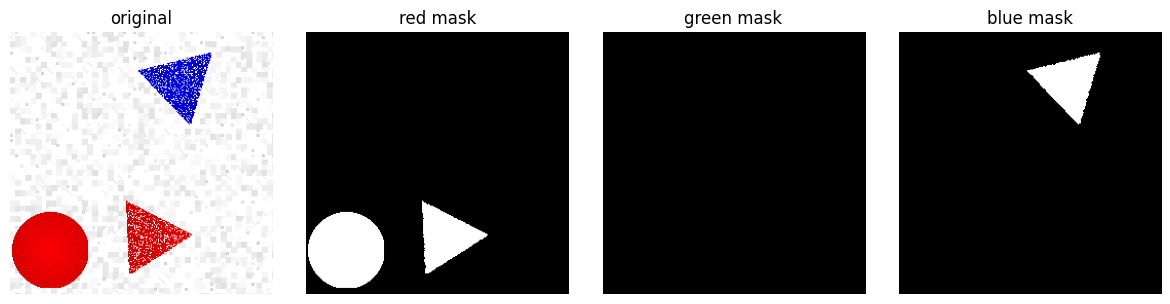

GT: [('circle', 'red'), ('triangle', 'red'), ('triangle', 'blue')]
  red probs [circle,square,triangle]: [0.999 0.012 0.998]
green probs [circle,square,triangle]: [0.016 0.014 0.046]
 blue probs [circle,square,triangle]: [0.005 0.008 1.   ]
PRED: [('circle', 'red'), ('triangle', 'red'), ('triangle', 'blue')]
Single-image Jaccard: 1.0000


In [74]:
inspect_single_row(hy_val_df, row_idx=33, model=hy_model, use_morph=USE_MORPH)

##Metrics

In [76]:
import ast, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from collections import defaultdict

COLORS = ["red","green","blue"]
SHAPES = ["circle","square","triangle"]
CLASS9 = [
    ("circle","red"),   ("circle","green"),   ("circle","blue"),
    ("square","red"),   ("square","green"),   ("square","blue"),
    ("triangle","red"), ("triangle","green"), ("triangle","blue"),
]
CLASS9_STR = [f"{s}_{c}" for (s,c) in CLASS9]


def jaccard_rows(y_true_bin, y_pred_bin):
    # per-image Jaccard (vectorized), returns (N,)
    inter = np.logical_and(y_true_bin, y_pred_bin).sum(axis=1)
    union = np.logical_or (y_true_bin, y_pred_bin).sum(axis=1)
    jac = np.where(union==0, 1.0, inter/union)
    return jac


def confusion_tp_fp_fn_tn(Y, Yhat):
    # Y, Yhat: (N,9) in {0,1}
    out = np.zeros((9,4), dtype=np.int64)
    for k in range(9):
        yk = Y[:,k]; pk = Yhat[:,k]
        tp = ((pk==1) & (yk==1)).sum()
        fp = ((pk==1) & (yk==0)).sum()
        fn = ((pk==0) & (yk==1)).sum()
        tn = ((pk==0) & (yk==0)).sum()
        out[k] = [tp, fp, fn, tn]
    return out


def bucketed_jaccard_by_count(Y, Yhat, df_val, by="num_shapes"):
    """
    Computes mean Jaccard per bucket (e.g., images with 1,2,3 shapes).
    """
    # rebuild per-image counts from df_val labels
    counts = []
    for _, row in df_val.reset_index(drop=True).iterrows():
        gt = set(parse_label_str(row.get("label","[]")))
        if by == "num_shapes":
            # count distinct shapes present regardless of color
            shapes_present = set(s for (s, c) in gt)
            counts.append(len(shapes_present))
        elif by == "num_colors":
            colors_present = set(c for (s, c) in gt)
            counts.append(len(colors_present))
        else:
            raise ValueError("by must be 'num_shapes' or 'num_colors'")
    counts = np.array(counts)

    # per-image Jaccard
    jac = jaccard_rows(Y.astype(bool), Yhat.astype(bool))
    results = {}
    for k in np.unique(counts):
        mask = (counts == k)
        if mask.sum() > 0:
            results[int(k)] = float(jac[mask].mean())
    return results


def plot_confusion_tp_fp_fn_tn(tp_fp_fn_tn, class_names=CLASS9_STR, title="Confusion (per class)"):
    """
    tp_fp_fn_tn: array shape (9,4) with columns [TP, FP, FN, TN] (counts or rates)
    """
    fig, ax = plt.subplots(figsize=(8, 4.5))
    im = ax.imshow(tp_fp_fn_tn, aspect='auto', cmap='Blues')
    ax.set_xticks(range(4)); ax.set_xticklabels(["TP","FP","FN","TN"])
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)
    ax.set_title(title)
    for i in range(tp_fp_fn_tn.shape[0]):
        for j in range(4):
            ax.text(j, i, f"{tp_fp_fn_tn[i,j]:.0f}", va='center', ha='center', fontsize=9)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()




In [77]:
## Multiset Jaccard over shapes (ignoring color)


def _true_shape_counts_from_row(row):
    """Return counts [circle, square, triangle] ignoring color."""
    pairs = parse_label_str(row.get("label","[]"))
    cnt = np.zeros(3, dtype=int)  # [circle, square, triangle]
    for (s,c) in pairs:
        if s == "circle":   cnt[0] += 1
        elif s == "square": cnt[1] += 1
        elif s == "triangle": cnt[2] += 1
    return cnt


def _pred_shape_counts_from_bin9(pred_bin_row):
    """
    pred_bin_row: (9,) in CLASS9 order.
    Returns counts [circle, square, triangle] by summing over colors.
    """
    p = np.asarray(pred_bin_row).reshape(3,3)  # rows: shape, cols: color
    # row 0 = circle (r,g,b), row 1 = square, row 2 = triangle
    return p.sum(axis=1).astype(int)  # (3,)

def _multiset_jaccard_counts(true_cnt, pred_cnt):
    inter = np.minimum(true_cnt, pred_cnt).sum()
    union = np.maximum(true_cnt, pred_cnt).sum()
    return 1.0 if union == 0 else float(inter / union)


def bucketed_shape_multiset_jaccard(pred_bin9, df_val):
    """
    pred_bin9: (N,9) binary predictions per image (end-to-end or hybrid, image-level), in CLASS9 order.
    Returns dict: {#shapes_in_image: mean multiset Jaccard over shapes}
    """
    dfv = df_val.reset_index(drop=True)
    N = len(dfv)

    true_counts = np.stack([_true_shape_counts_from_row(dfv.iloc[i]) for i in range(N)])   # (N,3)
    pred_counts = np.stack([_pred_shape_counts_from_bin9(pred_bin9[i]) for i in range(N)]) # (N,3)

    # per-image multiset Jaccard (shapes only, ignore color)
    jac = np.array([_multiset_jaccard_counts(true_counts[i], pred_counts[i]) for i in range(N)])

    # bucket by true total # of shapes in the image
    totals = true_counts.sum(axis=1)
    out = {}
    for k in np.unique(totals):
        mask = (totals == k)
        if mask.sum() > 0:
            out[int(k)] = float(jac[mask].mean())
    return out


In [78]:
## For CNN model

@torch.no_grad()
def collect_cnn_preds(model, val_loader, device, thr=0.5):
    model.eval()
    all_probs, all_true = [], []
    for x, y in val_loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_true.append(y.numpy().astype(int))
    P = np.vstack(all_probs)
    Y = np.vstack(all_true)
    y_pred = (P >= thr).astype(int)
    return Y, y_pred, P


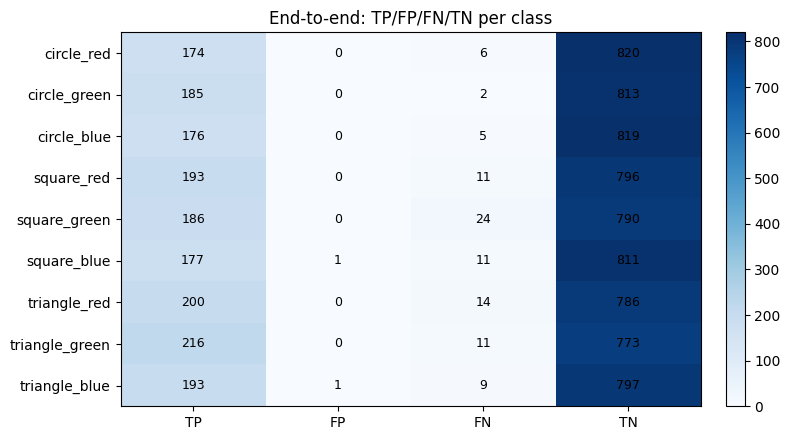

Bucketed shape multiset Jaccard: {0: 0.14857142857142858, 1: 0.2458893871449925, 2: 0.33253715498938424, 3: 0.3165144596651446, 4: 0.3180555555555555, 5: 0.28148148148148144}
Bucketed Jaccard by #colors: {0: 0.9759047619047617, 1: 0.9632132132132132, 2: 0.9785326086956521, 3: 0.9724462365591398}


/tmp/ipython-input-1152353439.py:18: RuntimeWarning: invalid value encountered in divide
  jac = np.where(union==0, 1.0, inter/union)


In [79]:
Y_true, Y_pred, Probs = collect_cnn_preds(cnn_model, cnn_dataloaders['val'], device, thr=0.5)
cm = confusion_tp_fp_fn_tn(Y_true, Y_pred)
plot_confusion_tp_fp_fn_tn(cm, CLASS9_STR, title="End-to-end: TP/FP/FN/TN per class")
# print("Bucketed Jaccard by #shapes:", bucketed_jaccard_by_count(Y_true, Y_pred, cnn_val_df, by="num_shapes"))
print("Bucketed shape multiset Jaccard:", bucketed_shape_multiset_jaccard(Y_pred, cnn_val_df))
print("Bucketed Jaccard by #colors:", bucketed_jaccard_by_count(Y_true, Y_pred, cnn_val_df, by="num_colors"))

In [80]:
## For hybrid model

@torch.no_grad()
def collect_hybrid_imagelevel(model, val_loader, df_val, device, thr=(0.5,0.5,0.5)):
    """
    Returns:
        Y_true: (N_images, 9) 0/1 ground truth
        Y_pred: (N_images, 9) 0/1 predictions after thresholding
        Probs : (N_images, 9) probabilities per class (aggregated)
    Class index order = CLASS9 (circle_red, circle_green, ..., triangle_blue)
    """
    model.eval()
    # accumulate per-color probs per image_idx
    per_image_pred = defaultdict(lambda: {c: np.zeros(3, dtype=float) for c in COLORS})
    for x, y, meta in val_loader:
        x = x.to(device)
        probs = torch.sigmoid(model(x)).cpu().numpy()   # (B,3)
        for i in range(len(probs)):
            img_idx = int(meta["image_idx"][i])
            color   = meta["color"][i]
            per_image_pred[img_idx][color] = probs[i]

    # build image-level 9-dim ground truth and probs
    dfv = df_val.reset_index(drop=True)
    N = len(dfv)
    Y_true = np.zeros((N, 9), dtype=int)
    Probs  = np.zeros((N, 9), dtype=float)

    class_pos = {p:i for i,p in enumerate(CLASS9)}
    for img_idx, row in dfv.iterrows():
        gt_pairs = set(parse_label_str(row.get("label","[]")))
        for (s,c) in gt_pairs:
            Y_true[img_idx, class_pos[(s,c)]] = 1
        # probs aggregation
        for color in COLORS:
            v = per_image_pred[img_idx][color]
            for s_i, shape in enumerate(SHAPES):
                Probs[img_idx, class_pos[(shape, color)]] = v[s_i]

    # threshold to get predictions
    thr9 = np.array([
        thr[0], thr[0], thr[0],   # circle r,g,b
        thr[1], thr[1], thr[1],   # square r,g,b
        thr[2], thr[2], thr[2],   # triangle r,g,b
    ])
    Y_pred = (Probs >= thr9).astype(int)

    return Y_true, Y_pred, Probs

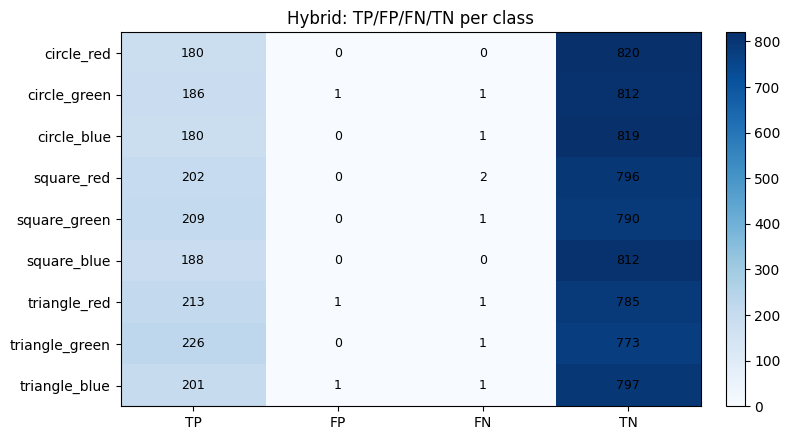

Bucketed shape multiset Jaccard: {0: 1.0, 1: 1.0, 2: 0.9973460721868366, 3: 0.9946727549467275, 4: 0.9891666666666666, 5: 0.9555555555555555}
Bucketed Jaccard by #colors: {0: 1.0, 1: 0.9984984984984985, 2: 0.9953804347826087, 3: 0.9931451612903226}


/tmp/ipython-input-1152353439.py:18: RuntimeWarning: invalid value encountered in divide
  jac = np.where(union==0, 1.0, inter/union)


In [81]:
Y_true_h, Y_pred_h, Probs_h = collect_hybrid_imagelevel(hy_model, hy_dataloaders['val'], hy_val_df, device, thr=(0.5,0.5,0.5))
cm_h = confusion_tp_fp_fn_tn(Y_true_h, Y_pred_h)
plot_confusion_tp_fp_fn_tn(cm_h, CLASS9_STR, title="Hybrid: TP/FP/FN/TN per class")
# print("Bucketed Jaccard by #shapes:", bucketed_jaccard_by_count(Y_true_h, Y_pred_h, hy_val_df, by="num_shapes"))
print("Bucketed shape multiset Jaccard:", bucketed_shape_multiset_jaccard(Y_pred_h, hy_val_df))
print("Bucketed Jaccard by #colors:", bucketed_jaccard_by_count(Y_true_h, Y_pred_h, hy_val_df, by="num_colors"))


##Submission

The following submission is for the hybrid model.

In [83]:
@torch.no_grad()
def predict_submission(test_csv, img_dir, model, out_csv, thresholds=(0.5,0.5,0.5), use_morph=True):
    model.eval()
    test_df = pd.read_csv(test_csv)
    rows = []
    for i, row in test_df.reset_index(drop=True).iterrows():
        img_path = Path(img_dir) / row["image_path"]
        bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        if bgr is None:
            raise FileNotFoundError(img_path)
        masks = color_masks_hsv(bgr)
        if use_morph:
            masks = {k: morph_clean(v) for k,v in masks.items()}

        per_color_probs = {}
        for c in COLORS:
            x = mask_to_tensor(masks[c]).unsqueeze(0).to(device)
            logits = model(x)
            probs  = torch.sigmoid(logits).squeeze(0).cpu().numpy()
            per_color_probs[c] = probs

        pred_set = agg_pred_sets(per_color_probs, thr=thresholds)
        rows.append({
            "image_path": row["image_path"],
            "label": tuples_to_string(pred_set)
        })

        if (i+1) % 200 == 0:
            print(f"Processed {i+1}/{len(test_df)} images...")

    sub = pd.DataFrame(rows)
    sub.to_csv(out_csv, index=False)
    print("Wrote submission to:", out_csv)


In [84]:
test_csv_path = ROOT / 'test.csv'
predict_submission(test_csv_path, IMG_DIR, hy_model, out_csv='/content/submission.csv')

Processed 200/1000 images...
Processed 400/1000 images...
Processed 600/1000 images...
Processed 800/1000 images...
Processed 1000/1000 images...
Wrote submission to: /content/submission.csv


In [86]:
submission_df = pd.read_csv('/content/submission.csv')

In [88]:
submission_df.head()

,image_path,label
0,test_dataset/img_0.png,"[('circle', 'red')]"
1,test_dataset/img_1.png,"[('circle', 'red')]"
2,test_dataset/img_2.png,"[('circle', 'red'), ('circle', 'green')]"
3,test_dataset/img_3.png,"[('circle', 'blue'), ('triangle', 'red'), ('tr..."
4,test_dataset/img_4.png,"[('square', 'green')]"


In [89]:
submission_df.loc[3, 'label']

"[('circle', 'blue'), ('triangle', 'red'), ('triangle', 'blue')]"

In [91]:
!cp /content/submission.csv "/content/drive/MyDrive/Kodiak Assignment/AliElhor_Submission.csv"